In [1]:
import copy

import torch
import gpytorch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import tqdm.notebook
import time
from sklearn import preprocessing
import glob
from skimage.measure import block_reduce
import tqdm.notebook
from datetime import datetime
import gc

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('classic')
import src.utils
from src.utils import set_gpytorch_settings
set_gpytorch_settings(False)
# Kernel Imports
from gpytorch.kernels import PeriodicKernel, ProductStructureKernel, AdditiveStructureKernel, ScaleKernel, RBFKernel, MaternKernel, LinearKernel, PolynomialKernel, SpectralMixtureKernel, GridInterpolationKernel, InducingPointKernel, ProductKernel, AdditiveKernel, GridKernel
from src.custom_kernel import MinKernel, AR2Kernel, MaternKernel, LinearKernel
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
# from gpytorch.kernels.keops import MaternKernel as FastMaternKernel
# from gpytorch.kernels.keops import RBFKernel as FastRBFKernel
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal
from gpytorch.constraints import Interval, GreaterThan
import itertools
# from gpytorch.metrics import mean_standardized_log_loss, quantile_coverage_error, mean_squared_error, mean_absolute_error
from src.custom_kernel import noise_lower, noise_upper, noise_init

['/home/dcaos/PycharmProjects/GaussProcesses/notebooks', '/home/dcaos/PycharmProjects/GaussProcesses', '/home/dcaos/anaconda3/lib/python310.zip', '/home/dcaos/anaconda3/lib/python3.10', '/home/dcaos/anaconda3/lib/python3.10/lib-dynload', '', '/home/dcaos/.local/lib/python3.10/site-packages', '/home/dcaos/anaconda3/lib/python3.10/site-packages', '/home/dcaos/anaconda3/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '/home/dcaos/anaconda3/lib/python3.10/site-packages/mpmath-1.2.1-py3.10.egg', '/home/dcaos/PycharmProjects/GaussProcesses']


In [2]:
# Reading data file and cleaning missing values
df = pd.read_feather('../Data/feather/46221_9999_wave_height.feather')
parameters_wave = ['time', 'wave_height']
parameters_temp = ['time', 'sea_surface_temperature']
df_as_np = df \
    .loc[:, parameters_wave] \
    .astype(float) \
    .replace(to_replace = [999.0, 99.0, 9999.0], value = np.nan) \
    .to_numpy()
using_sk = block_reduce(df_as_np, block_size=(24,1), func=np.mean).astype(float)
X = torch.tensor(using_sk[:-1,0]).float().cuda()
y = torch.tensor(using_sk[:-1,1]).float().cuda()
X = X.reshape(-1,1)
y = y.reshape(-1,1)

X = X[~torch.any(y.isnan(), dim=1)]
y = y[~torch.any(y.isnan(), dim=1)]
y = y.flatten()
X_old = X


In [3]:
# Helper functions
def period_print(x, scale_factor_value):
    print(f"raw: {x}")
    print(f"seconds: {x * scale_factor_value}")
    print(f"minutes: {x * scale_factor_value / 60}")
    print(f"hours: {x * scale_factor_value / 60 / 60 }")
    print(f"days: {x * scale_factor_value / 60 / 60 / 24}")
    print(f"weeks: {x * scale_factor_value / 60 / 60 / 24 / 7}")
    print(f"months: {x * scale_factor_value / 60 / 60 / 24 / 30}")
    print(f"years: {x * scale_factor_value / 60 / 60 / 24 / 365}")

def period_convert(x, type_to_convert, scale_factor_val):
    match type_to_convert:
        case "raw":
            return x
        case "seconds":
            return x * scale_factor_val
        case "minutes":
            return x * scale_factor_val / 60
        case "hours":
            return x * scale_factor_val / 60 / 60
        case "days":
            return x * scale_factor_val / 60 / 60 / 24
        case "weeks":
            return x * scale_factor_val / 60 / 60 / 24 / 7
        case "months":
            return x * scale_factor_val / 60 / 60 / 24 / 30
        case "years":
            return x * scale_factor_val / 60 / 60 / 24 / 365

def period_convert_list(li, type_to_convert, scale_factor_val):
    converted_list = []
    for h in li:
        converted_list.append(period_convert(h, type_to_convert, scale_factor_val))
    return converted_list

def scaler(a, X_old=X_old, center=True):
    if center is True:
        a = a - X_old.min(0).values
    return a / (X_old.max(0).values - X_old.min(0).values)

def generate_kernel_instance(full_kernel_string):
    kernel_class_parsed = full_kernel_string.split("_")
    kernel_class_type = kernel_class_parsed[0]
    if len(kernel_class_parsed) > 1:
        kernel_class_value = kernel_class_parsed[1]
    else:
        kernel_class_value = ""

    match str(kernel_class_type):
        case "RBF":
            return copy.deepcopy(RBFKernel(
                lengthscale_constraint=GreaterThan(
                    0.000329)))
        case "Mat":
            nu_value = float(kernel_class_value[-3:])
            return copy.deepcopy(MaternKernel(lengthscale_constraint=GreaterThan(
                    0.000329), nu=nu_value))
        case "AR2":
            return copy.deepcopy(AR2Kernel(
                period_constraint=Interval(
                    lower_bound=1e-4, upper_bound=0.005),
                lengthscale_constraint=GreaterThan(
                    0.000329)))
        case "Per":
            match kernel_class_value:
                case "Arb":
                    return copy.deepcopy(PeriodicKernel(
                    period_length_constraint=Interval(
                        lower_bound=1e-4, upper_bound=0.005),
                    lengthscale_constraint=GreaterThan(
                        0.000329)))
                case "Week":
                    return copy.deepcopy(PeriodicKernel(
                        period_length_constraint=Interval(
                            lower_bound=1e-4, upper_bound=0.75,
                            initial_value=scaler(60*60*24*7, center=False))))
                case "Month":
                    return copy.deepcopy(PeriodicKernel(
                        period_length_constraint=Interval(
                            lower_bound=1e-4, upper_bound=0.75,
                            initial_value=scaler(60*60*24*30, center=False))))
                case "Year":
                    return copy.deepcopy(PeriodicKernel(
                        period_length_constraint=Interval(
                            lower_bound=1e-4, upper_bound=0.75,
                            initial_value=scaler(60*60*24*365, center=False))))


def make_kernel(name_of_kernel):
    return_kernel_list = []
    kernel_additive_terms = str(name_of_kernel).split('+')
    for add_term_index, add_term in enumerate(kernel_additive_terms):
        kernel_mult_terms = str(add_term).split("*")
        for mult_term_index, mult_term in enumerate(kernel_mult_terms):
            return_kernel_list.append(mult_term)
            if mult_term_index == 0:
                cum_prod = generate_kernel_instance(mult_term)
            else:
                cum_prod = cum_prod * generate_kernel_instance(mult_term)
        if add_term_index == 0:
            cum_sum = copy.deepcopy(ScaleKernel(cum_prod))
        else:
            cum_sum = cum_sum + copy.deepcopy(ScaleKernel(cum_prod))
    return copy.deepcopy(cum_sum)#, return_kernel_list

def add_new_kernel_term(original_kernel, new_kernel_term, operation):
    return str(original_kernel) + str(operation) + str(new_kernel_term)

    # if name_of_kernel == 'RBF':
    #     return RBFKernel(
    #         lengthscale_constraint=GreaterThan(
    #             0.00035
    #         )
    #     ).__getitem__(index)
    # if name_of_kernel.startswith('Mat'):
    #     nu_value = float(name_of_kernel[-3:])
    #     return MaternKernel(lengthscale_constraint=GreaterThan(
    #             0.00035
    #         ), nu=nu_value)
    # if name_of_kernel == 'AR2':
    #     return AR2Kernel(
    #         period_constraint=Interval(
    #             lower_bound=1e-4, upper_bound=0.005),
    #         lengthscale_constraint=GreaterThan(
    #             0.00035
    #         ))
    # if name_of_kernel.startswith('Per'):
    #     if name_of_kernel.startswith('Per_Arb'):
    #         return PeriodicKernel(
    #             period_length_constraint=Interval(
    #                 lower_bound=1e-4, upper_bound=0.75)).__getitem__(index)
    #     elif name_of_kernel == 'Per_Week':
    #         return PeriodicKernel(
    #             period_length_constraint=Interval(
    #                 lower_bound=1e-4, upper_bound=0.75,
    #             initial_value=scaler(60*60*24*7, center=False)))
    #     elif name_of_kernel == 'Per_Month':
    #         return PeriodicKernel(
    #             period_length_constraint=Interval(
    #                 lower_bound=1e-4, upper_bound=0.75,
    #             initial_value=scaler(60*60*24*30, center=False)))
    # else:
    #     raise ValueError('Kernel not found')


def descaler(a, X_old=X_old, center=True):
    if center is True:
        a = a * (X_old.max(0).values - X_old.min(0).values)
    return a + X_old.min(0).values

# GP Model Declaration
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



In [4]:
# make_kernel("RBF+Per_Arb*Per_Week")

Scale Max: 1677108352.0
 Scale Min: 1349069952.0
 Scale Factor: 328038400.0
Before Block Reduce: (174818, 2)
After Block Reduce: (7285, 2)
Number of Nans: 0
Start Time: 2012-09-30 16:55:44
End Time: 2023-02-22 23:25:52
Number of Days: 3642.0416666666665
Time Period (Days): 3797.312592592593


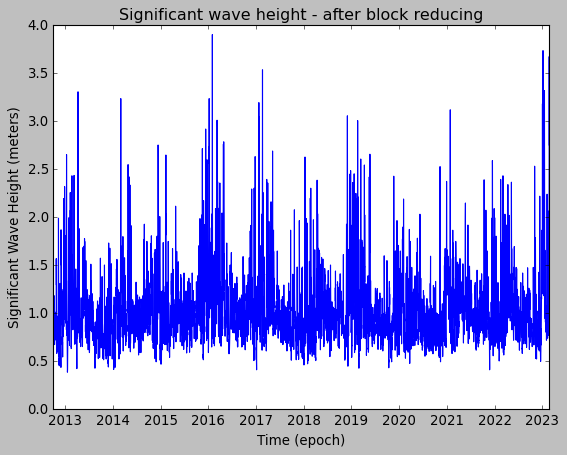

In [5]:
from numpy.ma import indices

# Scale the time axis and log transform the Y-values
X = scaler(X, X_old)
y = y.log()

# max, min, and scale factor declaration
scaler_max = X_old.max(0).values.item()
scaler_min = X_old.min(0).values.item()
scale_factor = scaler_max - scaler_min
print(f'Scale Max: {scaler_max}\n Scale Min: {scaler_min}\n Scale Factor: {scale_factor}')
temp_for_plotting = pd.Series(using_sk[:-1,0]*1e9, dtype='datetime64[ns]')
plt.plot(temp_for_plotting, using_sk[:-1,1])

# plt.plot(y.cpu().numpy())
# print(y)
plt.xlabel("Time (epoch)")
plt.ylabel("Significant Wave Height (meters)")
plt.title(f'Significant wave height - after block reducing')

print(
    f'Before Block Reduce: {df_as_np.shape}\n'
    f'After Block Reduce: {using_sk.shape}\n'
    f'Number of Nans: {np.count_nonzero(np.isnan(df_as_np))}\n'
    f'Start Time: {datetime.fromtimestamp(df_as_np[0,0])}\n'
    f'End Time: {datetime.fromtimestamp(df_as_np[-1,0])}\n'
    f'Number of Days: {df_as_np.shape[0]/48}\n'
    f'Time Period (Days): {(df_as_np[-1,0] - df_as_np[0,0]) / 24 / 60 / 60}')

# Prediction range, training and test set define
predict_days_out = 14
test_n = 2*predict_days_out
train_x = X[test_n:].contiguous().cuda()
train_y = y[test_n:].contiguous().cuda()
test_x = X[-test_n:].contiguous().cuda()
test_y = y[-test_n:].contiguous().cuda()

# Generate the train_loader and train_dataset
train_loader, train_dataset, test_loader, test_dataset = src.utils.create_train_loader_and_dataset(
    train_x, train_y, test_x, test_y)
data_compact = [train_x, train_y, test_x, test_y, train_loader, train_dataset, test_loader, test_dataset]

In [6]:
# List of possible Kernels terms
# Long-term dependence
smooth_kernel_list_t1 = ['RBF']#'', '', '', '']#, 'Mat0.5', 'Mat1.5', 'Mat2.5']
# Medium-term dependence
smooth_kernel_list_t2 = ['Mat2.5']#, 'Mat2.5']#['RBF', 'Mat0.5', 'Mat1.5',
# Fixed Monthly Period
periodic_kernel_list_t3 = ['Per_Month']
# Cyclic period
smooth_kernel_list_t4 = ['RBF']#, 'Mat0.5', 'Mat1.5', 'Mat2.5']
periodic_kernel_list_t4 = ['Per_Arb']#['Per_Arb', 'Per_Week',

periodic_kernel_list_tn = ['RBF', 'Per_Arb', 'Per_Arb', 'Per_Arb', 'Per_Arb', 'Per_Arb','', '', '', '', '', '', '']

baseline_kernel_list = []
for i in itertools.product(*[smooth_kernel_list_t1, smooth_kernel_list_t2, periodic_kernel_list_t3, periodic_kernel_list_t4, smooth_kernel_list_t4]):
    baseline_kernel_list.append(i)

n_kernel_list = []
for i in itertools.combinations(periodic_kernel_list_tn, r=6):
    n_kernel_list.append(i)
n_k_l = list(pd.DataFrame(n_kernel_list).drop_duplicates(keep='first').iloc[:6, :].itertuples(index=False, name=None))
n_k_l.reverse()


kernel_operations = ["+", "*"]
kernel_list = ["Per_Arb", "RBF", "Per_Month"]




print(n_k_l)

[('RBF', '', '', '', '', ''), ('RBF', 'Per_Arb', '', '', '', ''), ('RBF', 'Per_Arb', 'Per_Arb', '', '', ''), ('RBF', 'Per_Arb', 'Per_Arb', 'Per_Arb', '', ''), ('RBF', 'Per_Arb', 'Per_Arb', 'Per_Arb', 'Per_Arb', ''), ('RBF', 'Per_Arb', 'Per_Arb', 'Per_Arb', 'Per_Arb', 'Per_Arb')]


Using available CUDA


Training_exactGPRBF+Per_Arb:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00346: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00852: reducing learning rate of group 0 to 2.5000e-03.
Epoch 00865: reducing learning rate of group 0 to 1.2500e-03.
Epoch 00880: reducing learning rate of group 0 to 6.2500e-04.
Epoch 00885: reducing learning rate of group 0 to 3.1250e-04.
Epoch 00890: reducing learning rate of group 0 to 1.5625e-04.
Epoch 00895: reducing learning rate of group 0 to 7.8125e-05.
Epoch 00904: reducing learning rate of group 0 to 3.9063e-05.
Epoch 00909: reducing learning rate of group 0 to 1.9531e-05.
Epoch 00914: reducing learning rate of group 0 to 9.7656e-06.
Epoch 00920: reducing learning rate of group 0 to 4.8828e-06.
Epoch 00925: reducing learning rate of group 0 to 2.4414e-06.
Epoch 00930: reducing learning rate of group 0 to 1.2207e-06.
Epoch 00935: reducing learning rate of group 0 to 6.1035e-07.
Epoch 00940: reducing learning rate of group 0 to 3.0518e-07.
Epoch 00945: reducing learning rate of group 0 to 1.5259e-07.
Epoch 00

/home/dcaos/anaconda3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Using available CUDA


Training_exactGPRBF+Per_Arb*Per_Arb:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00046: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00051: reducing learning rate of group 0 to 2.5000e-03.
Epoch 00056: reducing learning rate of group 0 to 1.2500e-03.
Epoch 00061: reducing learning rate of group 0 to 6.2500e-04.
Epoch 00066: reducing learning rate of group 0 to 3.1250e-04.
Epoch 00071: reducing learning rate of group 0 to 1.5625e-04.
Epoch 00076: reducing learning rate of group 0 to 7.8125e-05.
Epoch 00081: reducing learning rate of group 0 to 3.9063e-05.
Epoch 00086: reducing learning rate of group 0 to 1.9531e-05.
Epoch 00091: reducing learning rate of group 0 to 9.7656e-06.
Epoch 00096: reducing learning rate of group 0 to 4.8828e-06.
Epoch 00101: reducing learning rate of group 0 to 2.4414e-06.
Epoch 00106: reducing learning rate of group 0 to 1.2207e-06.
Epoch 00111: reducing learning rate of group 0 to 6.1035e-07.
Epoch 00116: reducing learning rate of group 0 to 3.0518e-07.
Epoch 00121: reducing learning rate of group 0 to 1.5259e-07.
Epoch 00

/home/dcaos/anaconda3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Using available CUDA


Training_exactGPRBF+Per_Arb+RBF:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00284: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00289: reducing learning rate of group 0 to 2.5000e-03.
Epoch 00305: reducing learning rate of group 0 to 1.2500e-03.
Epoch 00310: reducing learning rate of group 0 to 6.2500e-04.
Epoch 00315: reducing learning rate of group 0 to 3.1250e-04.
Epoch 00323: reducing learning rate of group 0 to 1.5625e-04.
Epoch 00329: reducing learning rate of group 0 to 7.8125e-05.
Epoch 00334: reducing learning rate of group 0 to 3.9063e-05.
Epoch 00339: reducing learning rate of group 0 to 1.9531e-05.
Epoch 00344: reducing learning rate of group 0 to 9.7656e-06.
Epoch 00354: reducing learning rate of group 0 to 4.8828e-06.
Epoch 00359: reducing learning rate of group 0 to 2.4414e-06.
Epoch 00364: reducing learning rate of group 0 to 1.2207e-06.
Epoch 00369: reducing learning rate of group 0 to 6.1035e-07.
Epoch 00374: reducing learning rate of group 0 to 3.0518e-07.
Epoch 00379: reducing learning rate of group 0 to 1.5259e-07.
Epoch 00

/home/dcaos/anaconda3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Using available CUDA


Training_exactGPRBF+Per_Arb*RBF:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00644: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00649: reducing learning rate of group 0 to 2.5000e-03.
Epoch 00657: reducing learning rate of group 0 to 1.2500e-03.
Epoch 00662: reducing learning rate of group 0 to 6.2500e-04.
Epoch 00667: reducing learning rate of group 0 to 3.1250e-04.
Epoch 00674: reducing learning rate of group 0 to 1.5625e-04.
Epoch 00679: reducing learning rate of group 0 to 7.8125e-05.
Epoch 00684: reducing learning rate of group 0 to 3.9063e-05.
Epoch 00695: reducing learning rate of group 0 to 1.9531e-05.
Epoch 00700: reducing learning rate of group 0 to 9.7656e-06.
Epoch 00705: reducing learning rate of group 0 to 4.8828e-06.
Epoch 00710: reducing learning rate of group 0 to 2.4414e-06.
Epoch 00715: reducing learning rate of group 0 to 1.2207e-06.
Epoch 00720: reducing learning rate of group 0 to 6.1035e-07.
Epoch 00725: reducing learning rate of group 0 to 3.0518e-07.
Epoch 00730: reducing learning rate of group 0 to 1.5259e-07.
Epoch 00

/home/dcaos/anaconda3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Using available CUDA


Training_exactGPRBF+Per_Arb*RBF+Per_Month:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00264: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00274: reducing learning rate of group 0 to 2.5000e-03.
Epoch 00279: reducing learning rate of group 0 to 1.2500e-03.
Epoch 00300: reducing learning rate of group 0 to 6.2500e-04.
Epoch 00310: reducing learning rate of group 0 to 3.1250e-04.
Epoch 00315: reducing learning rate of group 0 to 1.5625e-04.
Epoch 00326: reducing learning rate of group 0 to 7.8125e-05.
Epoch 00331: reducing learning rate of group 0 to 3.9063e-05.
Epoch 00336: reducing learning rate of group 0 to 1.9531e-05.
Epoch 00344: reducing learning rate of group 0 to 9.7656e-06.
Epoch 00349: reducing learning rate of group 0 to 4.8828e-06.
Epoch 00354: reducing learning rate of group 0 to 2.4414e-06.
Epoch 00359: reducing learning rate of group 0 to 1.2207e-06.
Epoch 00364: reducing learning rate of group 0 to 6.1035e-07.
Epoch 00369: reducing learning rate of group 0 to 3.0518e-07.
Epoch 00374: reducing learning rate of group 0 to 1.5259e-07.
Epoch 00

/home/dcaos/PycharmProjects/GaussProcesses/src/utils.py:241: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, ax = plt.subplots(1, 1, figsize=(10, 7))
/home/dcaos/anaconda3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Kernel Structure (Best):  RBF+Per_Arb*RBF
Kernel Structure (Current Trial):  RBF+Per_Arb*RBF+Per_Month
Learning Rate:  0.01
BIC:  1643.515869140625
Iterations Number(n):  4
Kernel Params: kernels.0.raw_outputscale 0.10394101589918137
Kernel Params: kernels.0.base_kernel.raw_lengthscale 0.027868079021573067
Kernel Params: kernels.1.raw_outputscale 0.06933709979057312
Kernel Params: kernels.1.base_kernel.kernels.0.raw_lengthscale 2.164626121520996
Kernel Params: kernels.1.base_kernel.kernels.0.raw_period_length 0.003615699941292405
Kernel Params: kernels.1.base_kernel.kernels.1.raw_lengthscale 1.3868039846420288
Kernel Params: kernels.2.raw_outputscale 0.07919461280107498
Kernel Params: kernels.2.base_kernel.raw_lengthscale 1.9337109327316284
Kernel Params: kernels.2.base_kernel.raw_period_length 0.010342281311750412
Using available CUDA


Training_exactGPRBF+Per_Arb*RBF*Per_Month:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00191: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00289: reducing learning rate of group 0 to 2.5000e-03.
Epoch 00360: reducing learning rate of group 0 to 1.2500e-03.
Epoch 00365: reducing learning rate of group 0 to 6.2500e-04.
Epoch 00378: reducing learning rate of group 0 to 3.1250e-04.
Epoch 00385: reducing learning rate of group 0 to 1.5625e-04.
Epoch 00390: reducing learning rate of group 0 to 7.8125e-05.
Epoch 00396: reducing learning rate of group 0 to 3.9063e-05.
Epoch 00401: reducing learning rate of group 0 to 1.9531e-05.
Epoch 00406: reducing learning rate of group 0 to 9.7656e-06.
Epoch 00411: reducing learning rate of group 0 to 4.8828e-06.
Epoch 00416: reducing learning rate of group 0 to 2.4414e-06.
Epoch 00421: reducing learning rate of group 0 to 1.2207e-06.
Epoch 00426: reducing learning rate of group 0 to 6.1035e-07.
Epoch 00431: reducing learning rate of group 0 to 3.0518e-07.
Epoch 00436: reducing learning rate of group 0 to 1.5259e-07.
Epoch 00

/home/dcaos/anaconda3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


,0,1,2,3
0,RBF+Per_Arb,0,-1730.976440,AdditiveKernel(\n (kernels): ModuleList(\n ...
1,RBF+Per_Arb*Per_Arb,1,NaN,AdditiveKernel(\n (kernels): ModuleList(\n ...
2,RBF+Per_Arb+RBF,2,1634.621460,AdditiveKernel(\n (kernels): ModuleList(\n ...
3,RBF+Per_Arb*RBF,3,-2049.603760,AdditiveKernel(\n (kernels): ModuleList(\n ...
4,RBF+Per_Arb*RBF+Per_Month,4,1643.515869,AdditiveKernel(\n (kernels): ModuleList(\n ...
5,RBF+Per_Arb*RBF*Per_Month,5,1675.582642,AdditiveKernel(\n (kernels): ModuleList(\n ...


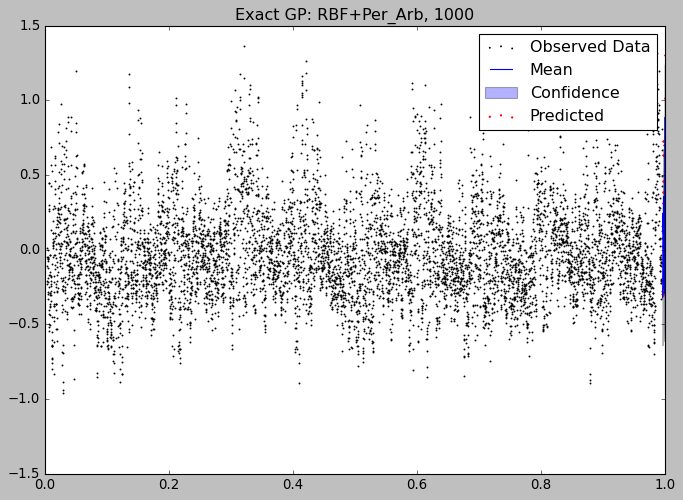

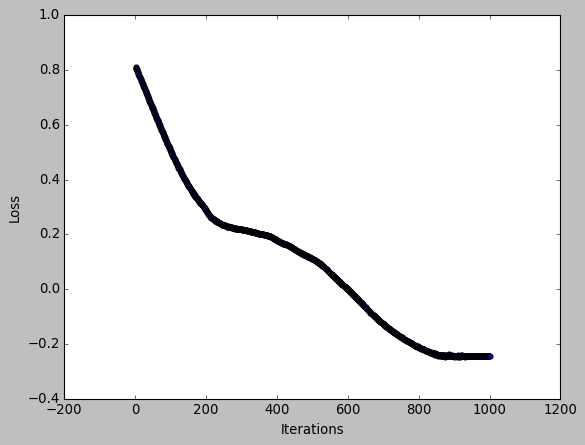

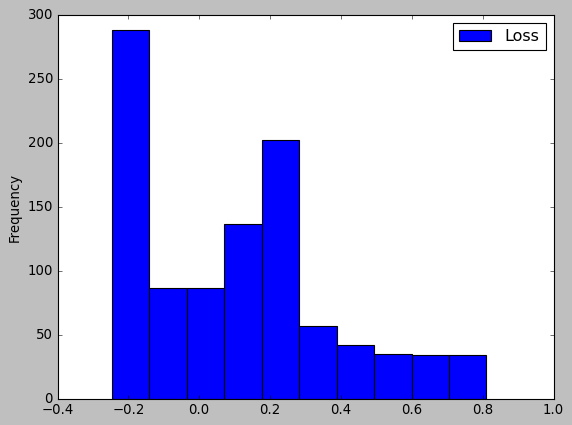

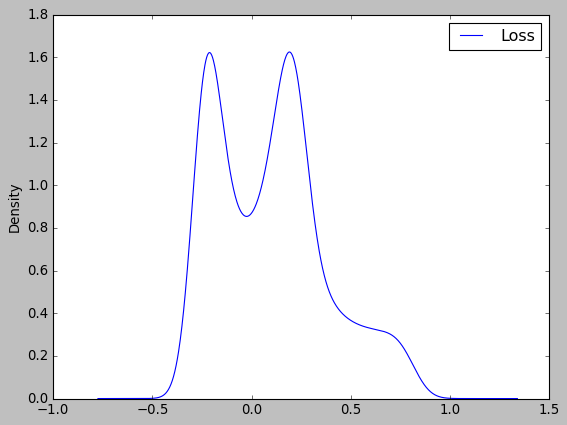

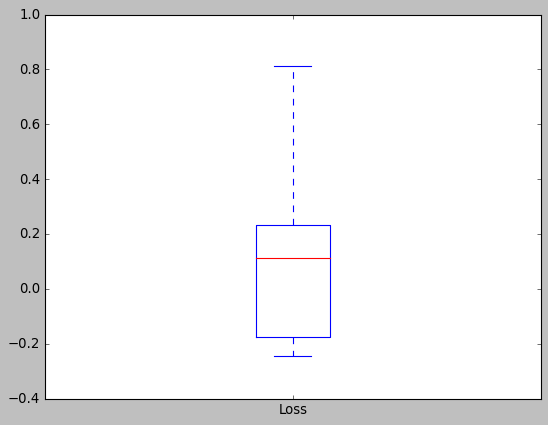

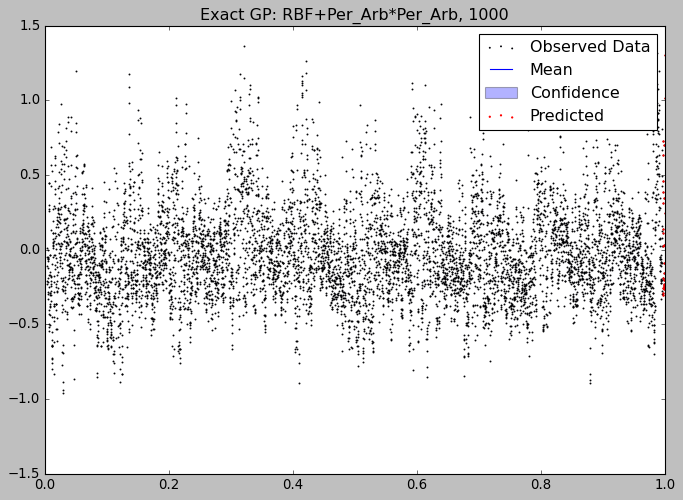

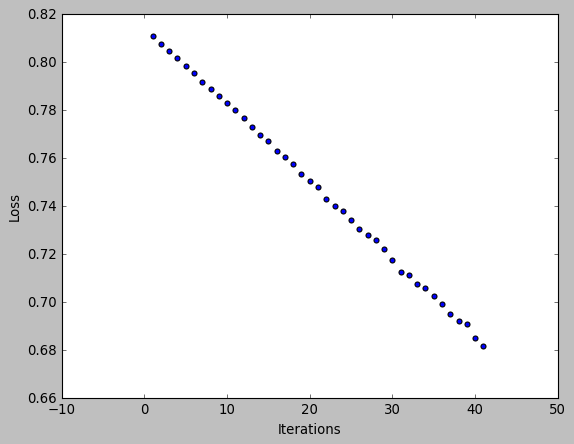

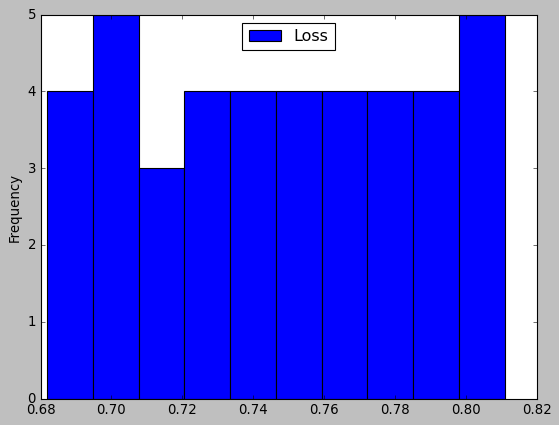

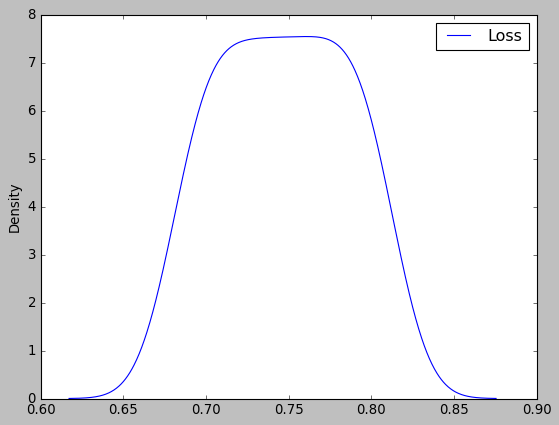

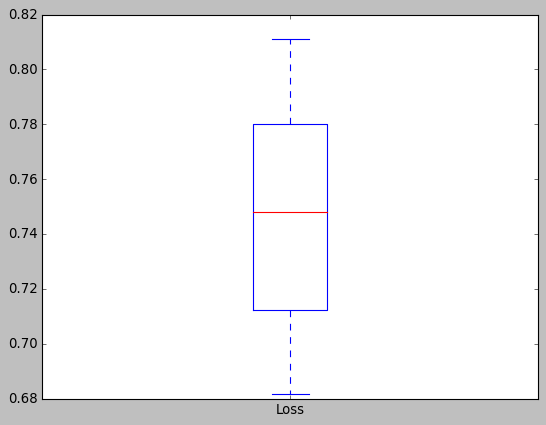

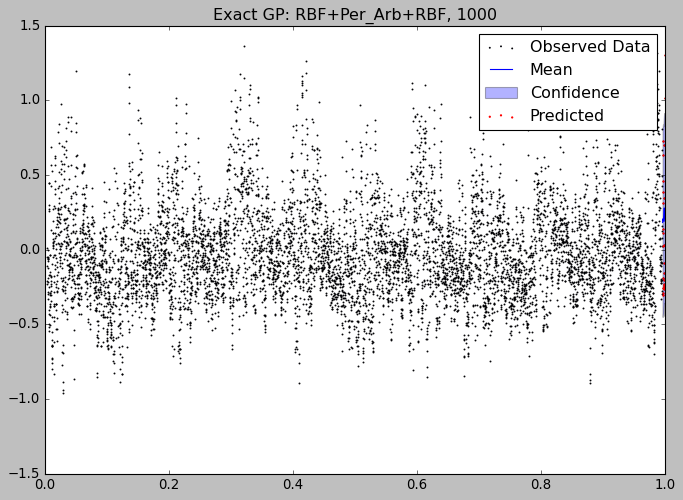

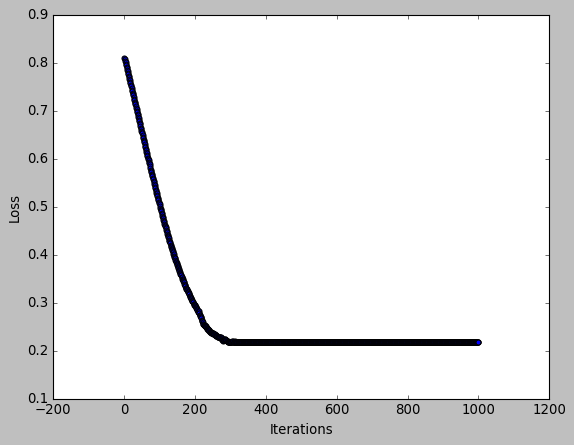

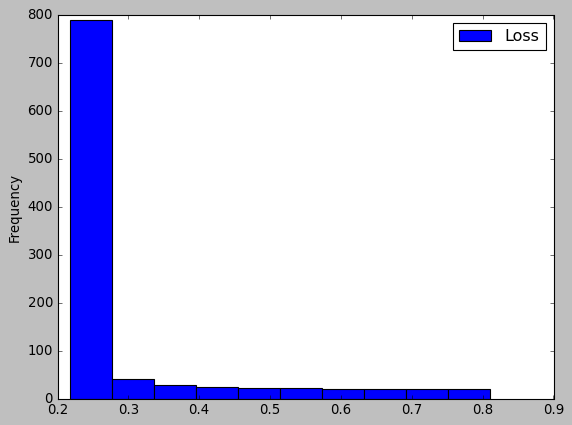

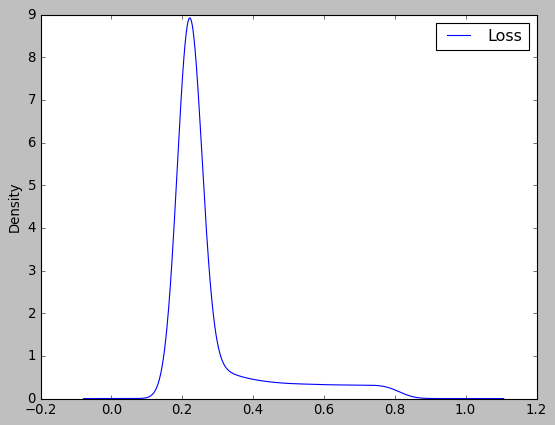

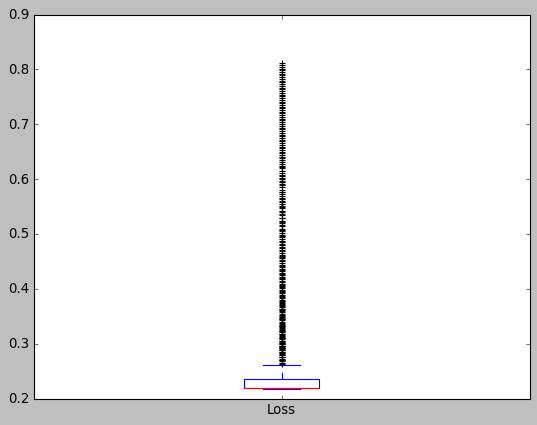

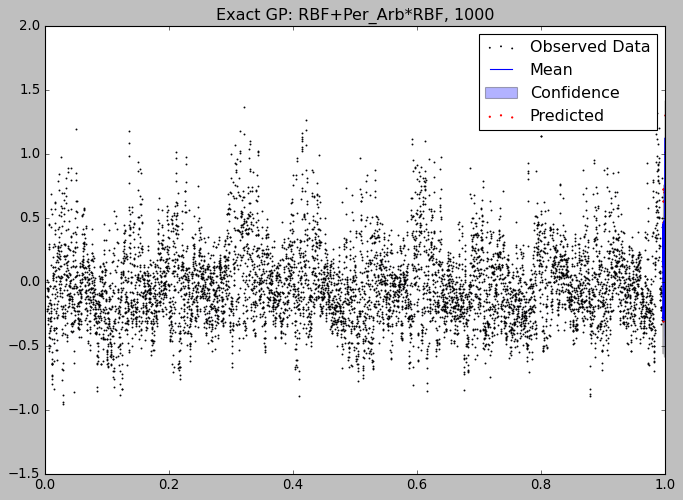

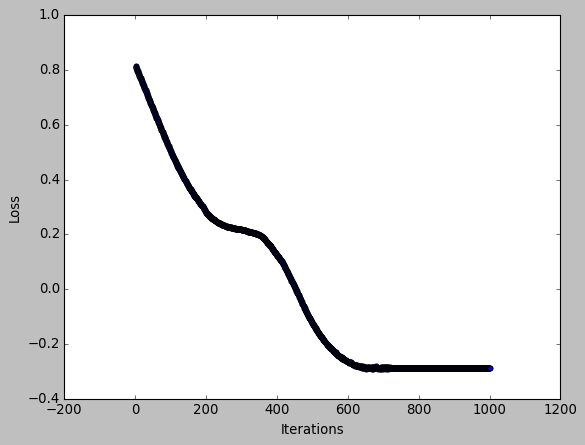

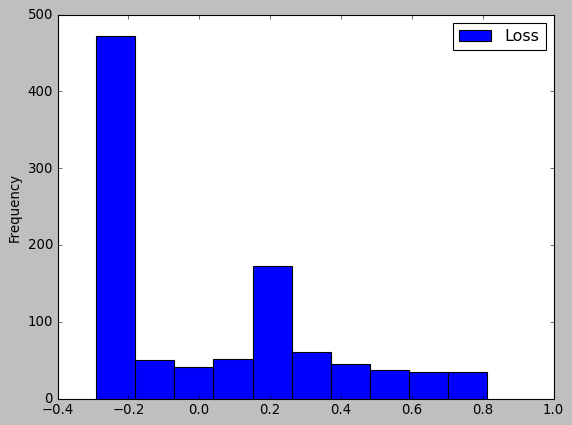

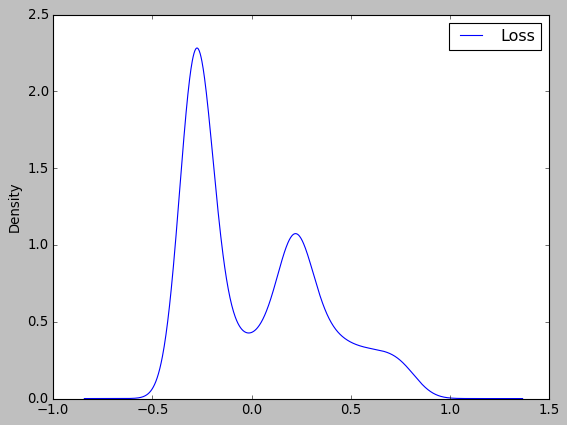

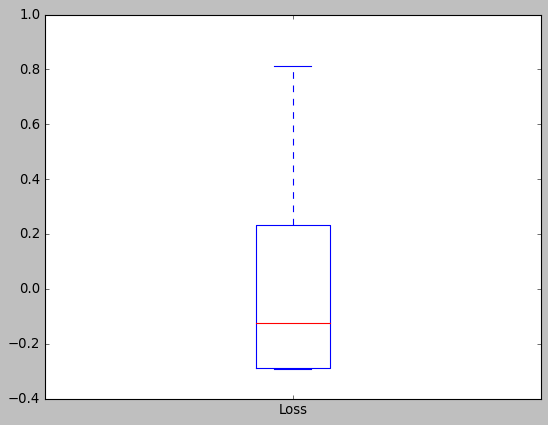

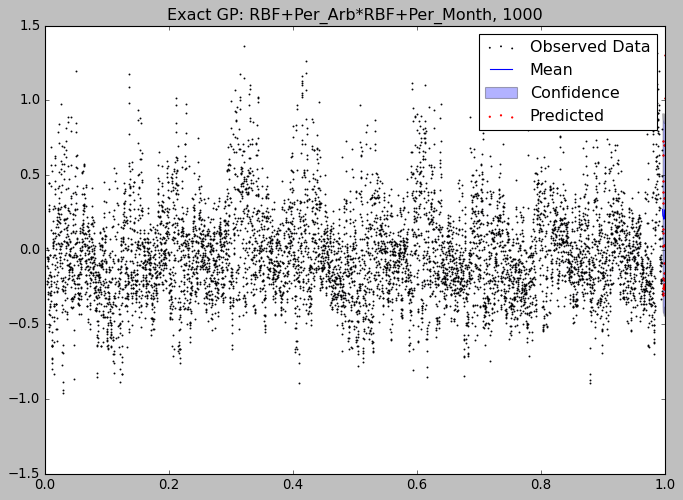

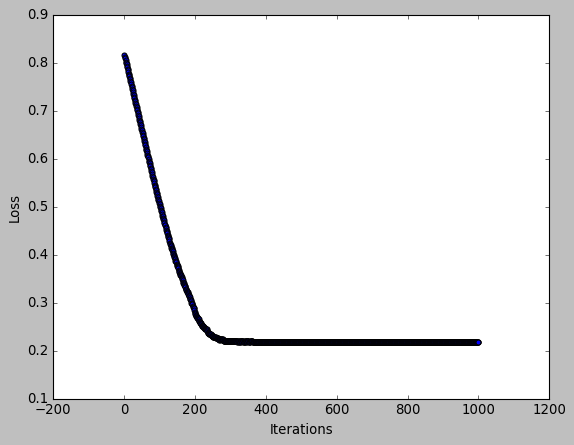

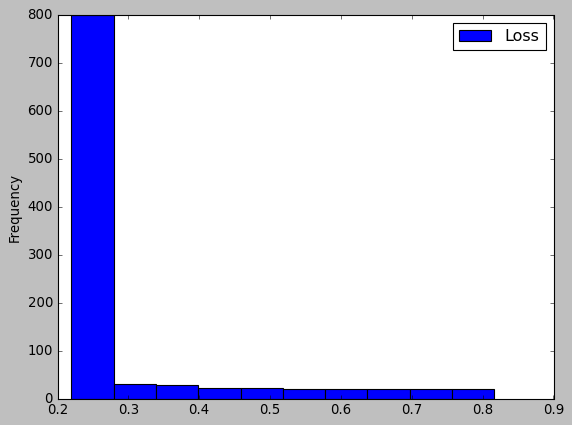

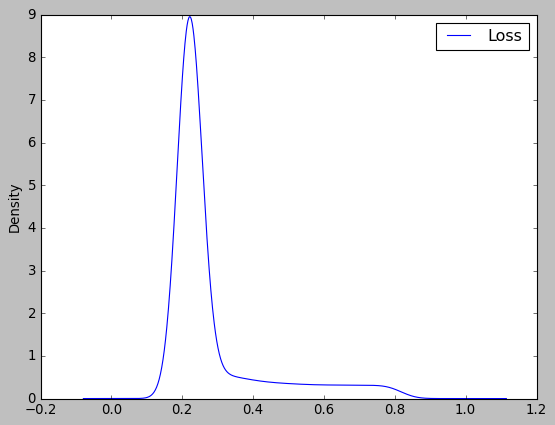

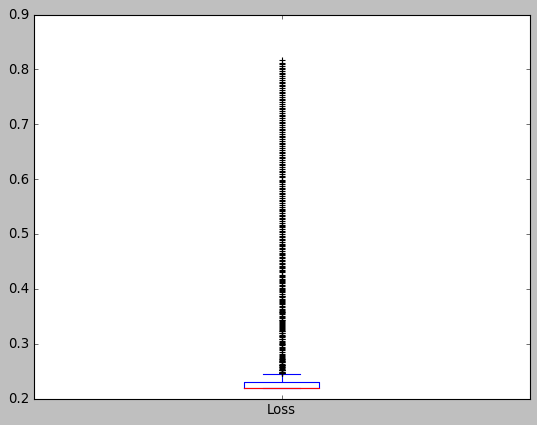

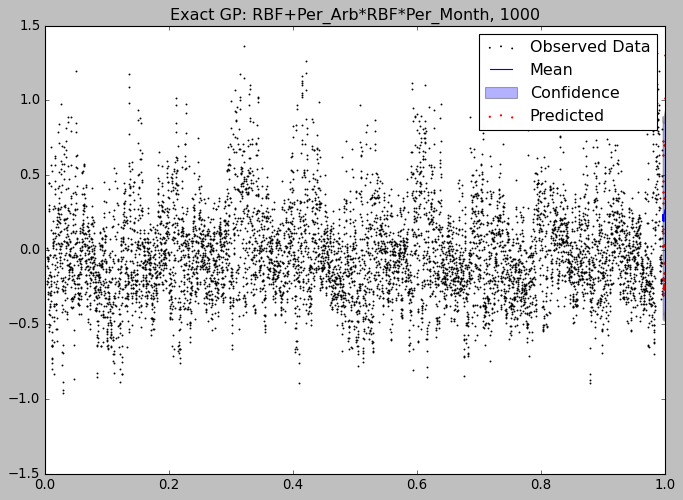

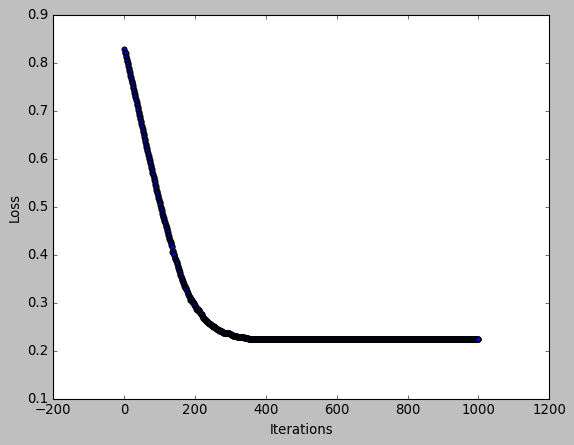

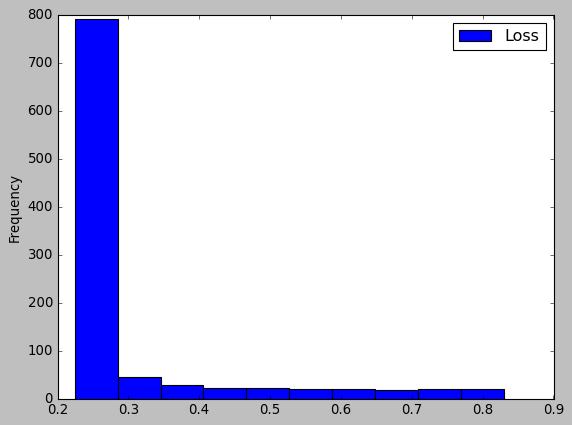

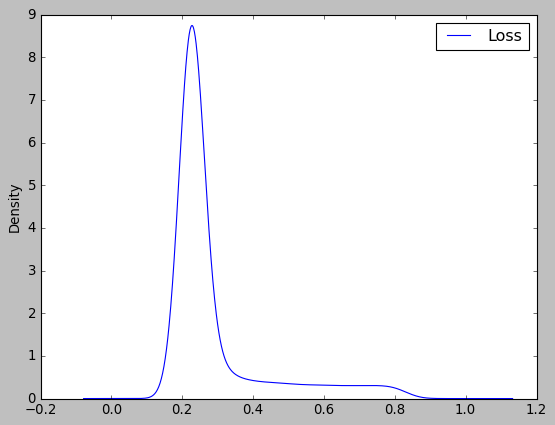

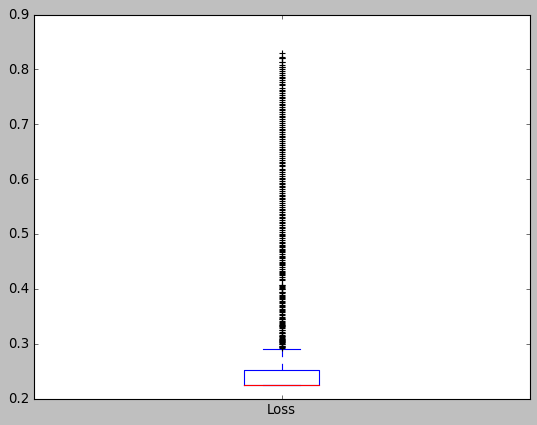

In [7]:
# Initializing empty list to record values
bic_save = []
n = 0
lr_check = 0.01#0.0063
# for k_i in n_k_l:#baseline_kernel_list
    # kernel = ScaleKernel(copy.deepcopy(make_kernel(k_i[0], index=n)))
    # for t_i in list(k_i)[1:]:
    #     if t_i == '':
    #         break
    #     kernel = kernel + (ScaleKernel(copy.deepcopy(make_kernel(t_i, index=n))))
list_of_kernels_to_try = [
    # ScaleKernel(
    #     RBFKernel(lengthscale_constraint=GreaterThan(0.00035))),
    # ScaleKernel(
    #     MaternKernel(lengthscale_constraint=GreaterThan(0.00035), nu=2.5)),
    # ScaleKernel(
    #         PeriodicKernel(period_length_constraint=Interval(
    #             lower_bound=1e-4, upper_bound=0.75))
    #         *RBFKernel(lengthscale_constraint=GreaterThan(0.00035))),
    # ScaleKernel(
    #         PeriodicKernel(period_length_constraint=Interval(
    #             lower_bound=1e-4, upper_bound=0.75,
    #             initial_value=scaler(60*60*24*30, center=False)))
    #         *RBFKernel(lengthscale_constraint=GreaterThan(0.00035))),
    ScaleKernel(
            PeriodicKernel(period_length_constraint=Interval(
                lower_bound=1e-4, upper_bound=0.75,
                initial_value=scaler(60*60*24*365, center=False)))
            *RBFKernel(lengthscale_constraint=GreaterThan(0.00035)))
]
list_of_kernels_to_try_2 = [1]
# for
with_and_without_scheduler = [True]
t_1, t_2, t_3, t_4, t_5 = 1, 0, 0, 0, 0
# for iter_list in with_and_without_scheduler:
#     if iter_list:
#         lr_check = 0.01
#     else:
#         lr_check = 0.0063
#     # kernel = copy.deepcopy(ScaleKernel(
#     #     RBFKernel(lengthscale_constraint=GreaterThan(0.00035))))
#     # kernel = copy.deepcopy(k_i) + kernel
kernel_at_runtime = \
    ScaleKernel(
        RBFKernel(lengthscale_constraint=GreaterThan(0.000329))) + \
    ScaleKernel(
        PeriodicKernel(period_length_constraint=Interval(
            lower_bound=1e-4, upper_bound=0.75)) * \
        RBFKernel(lengthscale_constraint=GreaterThan(0.000329))) #+ \
    # t_3 * ScaleKernel(
    #     PeriodicKernel(period_length_constraint=Interval(
    #         lower_bound=1e-4, upper_bound=0.75,
    #         initial_value=scaler(60*60*24*365, center=False)) \
    #     * RBFKernel(lengthscale_constraint=GreaterThan(0.000329)))) + \
    # t_4 * ScaleKernel(
    #         PeriodicKernel(period_length_constraint=Interval(
    #             lower_bound=1e-4, upper_bound=0.75,
    #             initial_value=scaler(60*60*24*30, center=False)) \
    #         * RBFKernel(lengthscale_constraint=GreaterThan(0.000329)))) + \
    # t_5 * ScaleKernel(
    #     AR2Kernel(lengthscale_constraint=GreaterThan(0.000329))) \




        # num_dims=6)
    # sk1, sk2, pk1, pk2, sk3 = k_i
    # kernel = ScaleKernel(make_kernel(sk1)) + ScaleKernel(make_kernel(sk2)) + ScaleKernel(make_kernel(pk1)) + ScaleKernel(make_kernel(pk2) * make_kernel(sk3))
    # kernel_name = f'{sk1}plus{sk2}plus{pk1}plus{sk3}x{pk2}_exact_gp'
    # k_list = [str(sk1), str(sk2), str(pk1), str(pk2), str(sk3)]
bic_values = [10000]
kernel_str_running = "RBF"
while bic_values[-1] > 0:
    for kernel_term_index, iter_kernel_terms in enumerate(kernel_list):
        for ops_index, iter_ops in enumerate(kernel_operations):
            kernel_str = add_new_kernel_term(kernel_str_running, iter_kernel_terms, iter_ops)
            kernel = copy.deepcopy(make_kernel(kernel_str))
            # kernel = kernel_at_runtime
            exact_gp = src.utils.TrainTestPlotSaveExactGP(
                ExactGPModel, kernel,
                train_x, train_y, test_x, test_y,
                num_iter=1000,
                lr=lr_check, #lr=0.0063, #lr=0.01,
                name=kernel_str,
                save_loss_values="save",
                use_scheduler=True)
            exact_gp.test_eval_exact_gp()
            exact_gp.plot(show_plot=False)
            bic_value = exact_gp.get_BIC()
            bic_save.append([
                kernel_str,
                n,
                bic_value.item(),
                kernel,])
            print("Kernel Structure (Best): ", kernel_str_running)
            print("Kernel Structure (Current Trial): ", kernel_str)
            if bic_value < bic_values[-1]:
                bic_values.append(bic_value)
                kernel_str_running = kernel_str
            else:
                kernel_str = kernel_str_running
                pass
            loss_df = pd.DataFrame(exact_gp.loss_values, columns=["Iterations", "Loss"])
            loss_df.plot(x="Iterations", y="Loss", kind='scatter')
            loss_df.plot(x="Iterations", y="Loss", kind='hist')
            loss_df.plot(x="Iterations", y="Loss", kind='kde')
            loss_df.plot(x="Iterations", y="Loss", kind='box')

            hyper_values = []
            output_scale = []
            # if n == 0:
            #     output_scale.append([kernel.outputscale.item()])
            # else:
            #     output_scale.append([kernel.kernels[0].outputscale.item()])
            # for pk in range(n+1):
            #     print(pk)
            #     if pk == 0:
            #         hyper_values.append([-9999])
            #     else:
            #         hyper_values.append([kernel.kernels[pk].base_kernel.period_length.item()])
            #         output_scale.append([kernel.kernels[pk].outputscale.item()])
            # output_scale = [
            #     kernel.kernels[0].outputscale.item(),
            #     kernel.kernels[1].outputscale.item(),
            #     kernel.kernels[2].outputscale.item(),
            #     kernel.kernels[3].outputscale.item()
            # ]
            # hyper_values = [
            #     kernel.kernels[0].base_kernel.lengthscale.item(),
            #     kernel.kernels[1].base_kernel.lengthscale.item(),
            #     kernel.kernels[2].base_kernel.lengthscale.item(),
            #     kernel.kernels[2].base_kernel.period_length.item(),
            #     kernel.kernels[3].base_kernel.kernels[0].lengthscale.item(),
            #     kernel.kernels[3].base_kernel.kernels[0].period_length.item(),
            #     kernel.kernels[3].base_kernel.kernels[1].lengthscale.item(),]

                # loss_df])
                #period_convert_list(hyper_values, "days", scale_factor),])
                # *hyper_values,
                # *k_i])

            print("Learning Rate: ", lr_check)
            # print("Kernel Structure: ", *k_i)
            print("BIC: ", exact_gp.get_BIC().item())
            print("Iterations Number(n): ",n)
            # print("Hyper Values: ", hyper_values)
            # print("Output Scale Values: ", output_scale)
            # print("Memory Check: ", torch.cuda.mem_get_info(device=None))
            # print("Kernel State Dict: ", kernel[0].state_dict())
            for iter_k in kernel.named_parameters_and_constraints():#kernel.named_hyperparameters():
                print("Kernel Params:", iter_k[0], iter_k[2].transform(iter_k[1]).item())
                # print("Kernel Params:", iter_k[0], iter_k[-1].item())
                # print("Kernel Params:", iter_k[0], iter_k[-1].item())
            # for iter_k in kernel.sub_kernels():
            #     if n == 0:
            #         continue
            #     print("Kernel Iter outscale: ", iter_k.outputscale.item())
            #     for iter_k_sub in iter_k.sub_kernels():
            #         print("Kernel Iter Lengthscale: ", iter_k_sub.lengthscale.item())

            # plt.plot(iterations_num, loss_vals)

            n += 1
            # lr_check += 0.0001
            del exact_gp
            del kernel
            gc.enable()
            gc.collect()
            torch.cuda.empty_cache()
column_names = [
        'Kernel_Name','n', 'BIC', 'Period_Length_(days)', 'Output_Scale', 'kernel_full', 'loss_df']
        # 's1_ls_converted', 's2_ls_converted','pk1_ls_converted', 'pk1_pr_converted', 'pk2_ls_converted', 'pk2_pr_converted', 's3_ls_converted',
        # 's1_ls_raw', 's2_ls_raw', 'pk1_ls_raw', 'pk1_pr_raw', 'pk2_ls_raw', 'pk2_pr_raw','s3_ls_raw',
        # 'add_scale1_K1', 'add_scale2_K2', 'add_period1_K3', 'scale3_mult_K4', 'scale3_mult_K4']
bic_out_df = pd.DataFrame(bic_save)
    # bic_save, columns=column_names)

# bic_out_df.to_csv('bic_save_linear_kernel_struct_baseline.csv')
# bic_out_df.to_csv('bic_save_linear_kernel_struct_rbf_arb_additive.csv')
bic_out_df

In [8]:
# kernel
# bic_out_df.to_csv("baseline_kernel_list_fixed_lower_bound_trial.csv")
#bic_out_df["kernel_full"][3].kernelsP
bic_out_df.to_csv("before_prez.csv")

,0,1,2,3
0,RBF+Per_Arb,0,-1730.976440,AdditiveKernel(\n (kernels): ModuleList(\n ...
1,RBF+Per_Arb*Per_Arb,1,NaN,AdditiveKernel(\n (kernels): ModuleList(\n ...
2,RBF+Per_Arb+RBF,2,1634.621460,AdditiveKernel(\n (kernels): ModuleList(\n ...
3,RBF+Per_Arb*RBF,3,-2049.603760,AdditiveKernel(\n (kernels): ModuleList(\n ...
4,RBF+Per_Arb*RBF+Per_Month,4,1643.515869,AdditiveKernel(\n (kernels): ModuleList(\n ...
5,RBF+Per_Arb*RBF*Per_Month,5,1675.582642,AdditiveKernel(\n (kernels): ModuleList(\n ...


In [9]:
bic_out_df.iloc[:, 2:-1].to_latex()
bic_out_df.iloc[:, 2:-1].to_latex(float_format="%.4f")



/tmp/ipykernel_106905/1756904919.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  bic_out_df.iloc[:, 2:-1].to_latex()
/tmp/ipykernel_106905/1756904919.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  bic_out_df.iloc[:, 2:-1].to_latex(float_format="%.4f")


'\\begin{tabular}{lr}\n\\toprule\n{} &          2 \\\\\n\\midrule\n0 & -1730.9764 \\\\\n1 &        NaN \\\\\n2 &  1634.6215 \\\\\n3 & -2049.6038 \\\\\n4 &  1643.5159 \\\\\n5 &  1675.5826 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [10]:
period_print(0.000329, scale_factor)
period_print(0.001419, scale_factor)
period_print(2.62, scale_factor)
# print(len(bic_save[0]))
# bic_save
# gc.enable()
# gc.collect()
# torch.cuda.empty_cache()
# torch.cuda.CUDAGraph().pool()

# baseline_df_master = pd.read_csv('Baseline_Kernel_Results.csv', index_col='BIC')
# baseline_df_master.to_csv('Baseline_Kernel_Results_bak.csv')
# # baseline_df_master = baseline_df_master.reset_index()
# baseline_df_master



# joined_baseline_df = pd.merge(right=baseline_df_master, left=bic_out_df, on='BIC', how='outer')
# pd.concat([baseline_df_master, bic_out_df], ignore_index=True)
# joined_baseline_df.to_csv('Baseline_Kernel_Results.csv')
# joined_baseline_df
# temp_list = []
# temp_list.append([*period_convert_list(hyper_values, "days", scale_factor)])
# temp_list


# print(bic_out_df["kernel_full"][3].kernels[0].outputscale.item(),
#     bic_out_df["kernel_full"][3].kernels[1].outputscale.item(),
#     bic_out_df["kernel_full"][3].kernels[2].outputscale.item(),
#     bic_out_df["kernel_full"][3].kernels[2].outputscale.item(),)
# print(bic_out_df["kernel_full"][3].kernels[0].outputscale.item()+bic_out_df["kernel_full"][3].kernels[2].outputscale.item())



# kernel.outputscale
# kernel.kernels[2].base_kernel.lengthscale.item(),

# for i in itertools.accumulate(periodic_kernel_list_tn, operator.add):
#     print(i)
# l1 = (['abc', 'def'])
# l2 = ['123', '456']
# l3 = ['---', 'xxx']
# list_of_lists = [l1, l2, l3]
# l4 = np.array([['rbf']])
# # for i in itertools.product(zip(smooth_kernel_list_t1, smooth_kernel_list_t2, periodic_kernel_list_t3, smooth_kernel_list_t4, periodic_kernel_list_t4)):
# for i in itertools.product(*[l1, l2, l3]):#*zip(l1, l2, l3)):
# # for i in itertools.product(*[smooth_kernel_list_t1, smooth_kernel_list_t2, periodic_kernel_list_t3, smooth_kernel_list_t4, periodic_kernel_list_t4]):
#     print(i, ": ")
#     print(i[1])
# # plt.plot(bic_out_df['BIC'])
# # vector_i = np.array([[1, 1, 1, 0]]).T
# # [a*b for a,b in zip(vector_i, l4)]
# # np.dot(vector_i, l4)
# kernel

# two_term_results = pd.read_csv("joined_results_4_7.csv")
# merged_df = pd.merge(bic_out_df, two_term_results, how="outer")
# merged_df.to_csv('merged_csv_messy.csv')
# merged_df

# kernel
# torch.cuda.current_device()
print(.000329**2, .000390**2)
# scale_factor = 328038400

raw: 0.000329
seconds: 107924.63359999999
minutes: 1798.743893333333
hours: 29.979064888888885
days: 1.2491277037037036
weeks: 0.1784468148148148
months: 0.04163759012345679
years: 0.00342226768138001
raw: 0.001419
seconds: 465486.4896
minutes: 7758.10816
hours: 129.30180266666667
days: 5.387575111111111
weeks: 0.7696535873015874
months: 0.17958583703703704
years: 0.014760479756468799
raw: 2.62
seconds: 859460608.0
minutes: 14324343.466666667
hours: 238739.05777777778
days: 9947.46074074074
weeks: 1421.06582010582
months: 331.582024691358
years: 27.253317097919837
1.0824099999999998e-07 1.521e-07
